<a href="https://colab.research.google.com/github/PranavDixit2/Dementia/blob/main/Alz_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Install Required Libraries
!pip install opencv-python tensorflow gradio kagglehub efficientnet

# Step 2: Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0  # Using EfficientNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils import class_weight
import kagglehub



In [ ]:
# Enable mixed precision
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)
tf.keras.mixed_precision.set_global_policy('mixed_float16')
# Step 3: Download Dataset from KaggleHub
print("Downloading dataset...")
path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset-v2")
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/augmented-alzheimer-mri-dataset-v2


In [ ]:
dataset_path = "/kaggle/input/augmented-alzheimer-mri-dataset-v2/data"
train_data_path = os.path.join(dataset_path, "train")
val_data_path = os.path.join(dataset_path, "val")

In [ ]:
# Function to explore the dataset
def explore_dataset(dataset_path):
    class_counts = {}
    total_images = 0

    # Check the structure
    for root, dirs, files in os.walk(dataset_path):
        for folder in dirs:
            folder_path = os.path.join(root, folder)
            num_files = len(os.listdir(folder_path))
            class_counts[folder] = num_files
            total_images += num_files

    print("Dataset Overview:")
    print(f"Total Classes: {len(class_counts)}")
    print(f"Total Images: {total_images}")
    print("Class Distribution:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count}")

    return class_counts

print("Exploring the dataset...")
class_counts = explore_dataset(dataset_path)



Exploring the dataset...
Dataset Overview:
Total Classes: 6
Total Images: 40392
Class Distribution:
  val: 4
  train: 4
  ModerateDemented: 6464
  NonDemented: 9600
  VeryMildDemented: 8960
  MildDemented: 8960


In [ ]:
# Step 4: Define the Target Classes
TARGET_CLASSES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Step 5: Filter Non-Target Folders from train and val directories
def filter_dataset(base_path, target_classes):
    for subfolder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, subfolder)
        if os.path.isdir(folder_path) and subfolder not in target_classes:
            print(f"Removing unrelated folder: {folder_path}")
            os.system(f"rm -rf '{folder_path}'")

filter_dataset(train_data_path, TARGET_CLASSES)
filter_dataset(val_data_path, TARGET_CLASSES)

Removing unrelated folder: /kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val
Removing unrelated folder: /kaggle/input/augmented-alzheimer-mri-dataset-v2/data/train
Removing unrelated folder: /kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val
Removing unrelated folder: /kaggle/input/augmented-alzheimer-mri-dataset-v2/data/train


In [ ]:
# Step 6: Setup ImageDataGenerators without Data Augmentation
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 16
SEED = 42

train_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

# Step 7: Load images using flow_from_directory
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    val_data_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

Found 33984 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


Sample Augmented Training Images:


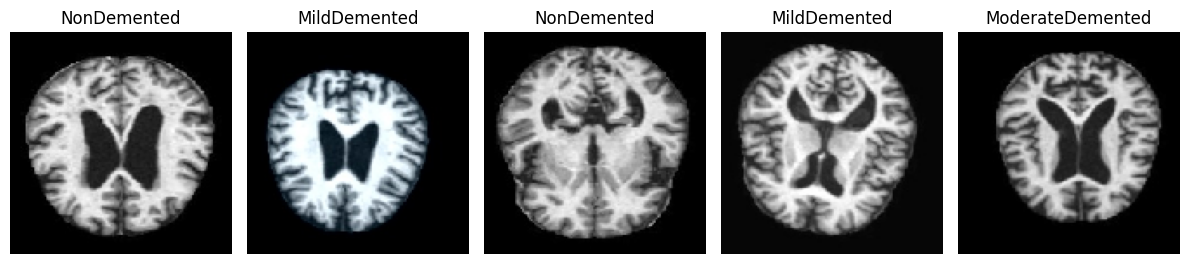

In [ ]:
# Step 8: Visualize Some Sample Images from Train Generator
def plot_augmented_images(data_gen, class_indices, num_samples=5):
    label_map = {v: k for k, v in class_indices.items()}
    images, labels = next(data_gen)

    plt.figure(figsize=(12, 5))
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(label_map[np.argmax(labels[i])])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

print("Sample Augmented Training Images:")
plot_augmented_images(train_generator, train_generator.class_indices)


In [ ]:
# Step 8: Compute Class Weights
class_labels = list(train_generator.class_indices.keys())
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights_dict = dict(zip(np.unique(train_generator.classes), class_weights))
print("Computed Class Weights:", class_weights_dict)



Computed Class Weights: {np.int32(0): np.float64(0.9482142857142857), np.int32(1): np.float64(1.3143564356435644), np.int32(2): np.float64(0.885), np.int32(3): np.float64(0.9482142857142857)}


In [ ]:
# Step 9: Define the Model
def create_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False  # Freeze the base
        # Freeze the base model
    base_model.trainable = False

    # Add custom layers on top
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(TARGET_CLASSES), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Create and compile the model
model = create_model()
model.summary()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 128, 128, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 128, 128, 3)    │              0 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 128, 128, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 129, 129, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 64, 64, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 64, 64, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 64, 64, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 64, 64, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)             

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Step 10: Train the Model
print("Starting model training...")
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/best_model.keras', save_best_only=True),  # Save in Keras format
    ReduceLROnPlateau(patience=3)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    class_weight=class_weights_dict,  # Use computed class weights
    callbacks=callbacks
)

print("Model training completed.")



Starting model training...
Epoch 1/5
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 4204s 2s/step - accuracy: 0.2518 - loss: 1.3926 - val_accuracy: 0.3500 - val_loss: 1.3855 - learning_rate: 1.0000e-04
Epoch 2/5
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 4208s 2s/step - accuracy: 0.2541 - loss: 1.3870 - val_accuracy: 0.5000 - val_loss: 1.3853 - learning_rate: 1.0000e-04
Epoch 3/5
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 4209s 2s/step - accuracy: 0.2660 - loss: 1.3861 - val_accuracy: 0.1400 - val_loss: 1.3865 - learning_rate: 1.0000e-04
Epoch 4/5
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 4186s 2s/step - accuracy: 0.2132 - loss: 1.3882 - val_accuracy: 0.1400 - val_loss: 1.3861 - learning_rate: 1.0000e-04
Epoch 5/5
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 4210s 2s/step - accuracy: 0.2555 - loss: 1.3856 - val_accuracy: 0.3500 - val_loss: 1.3860 - learning_rate: 1.0000e-04
Model training completed.


Evaluating the model...
400/400 ━━━━━━━━━━━━━━━━━━━━ 662s 2s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00       896
ModerateDemented       0.00      0.00      0.00        64
     NonDemented       0.50      1.00      0.67      3200
VeryMildDemented       0.00      0.00      0.00      2240

        accuracy                           0.50      6400
       macro avg       0.12      0.25      0.17      6400
    weighted avg       0.25      0.50      0.33      6400



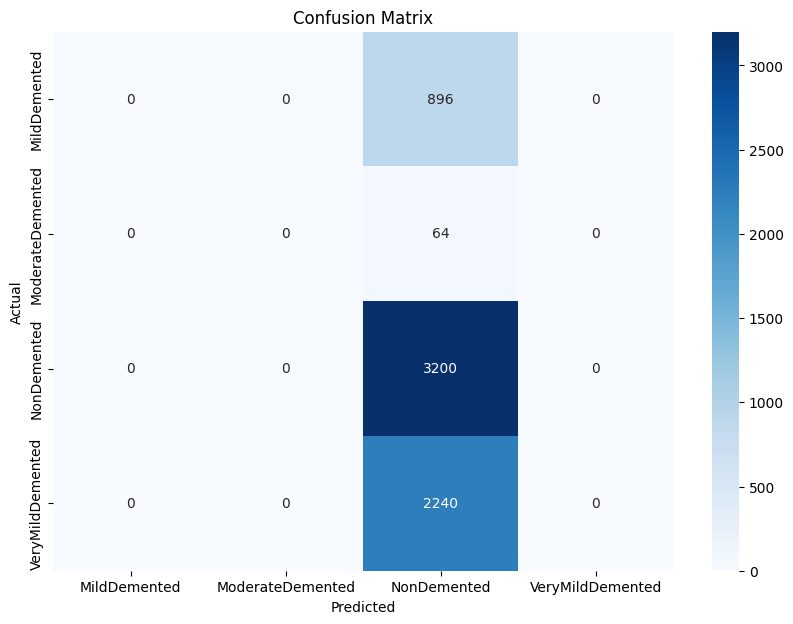

In [ ]:
# Step 11: Evaluate the Model
print("Evaluating the model...")
val_predictions = model.predict(val_generator)
val_predictions_classes = np.argmax(val_predictions, axis=1)

# Generate classification report
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())
report = classification_report(true_classes, val_predictions_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(true_classes, val_predictions_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()



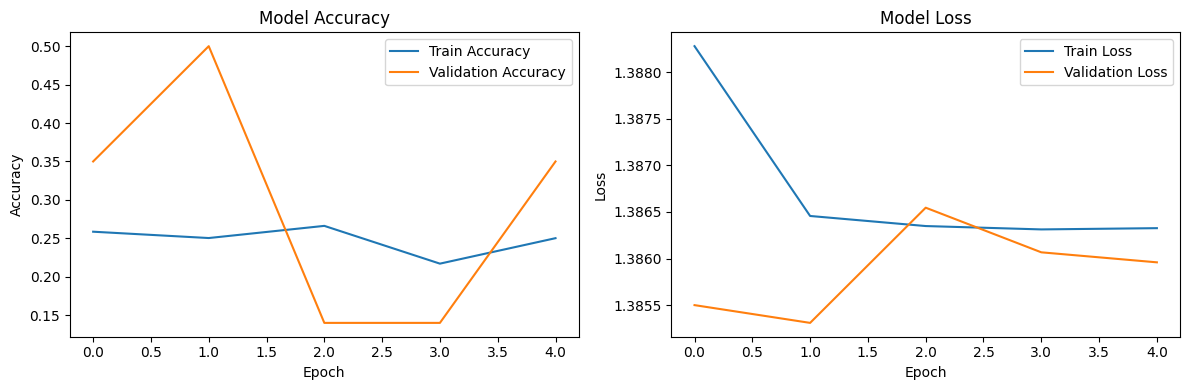

Model evaluation completed.


In [ ]:
# Step 12: Visualize Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("Model evaluation completed.")